In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import analyze_cells_energy as ace
import re
import utils
import itertools
import seaborn as sns
import utils_PLS as upls

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
batch='c57'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres.npy', allow_pickle=True).item()

In [4]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

# Format data for task PLS

In [5]:
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

# Format data for hierarchy plotting

In [6]:
df_levels = upls.create_df_levels(volumes)

# Apply task PLS

In [7]:
%%bash
python area_pls.py -i results_pls/c57_n_cells.csv -o './results_pls/c57_ncells'

In [8]:
%%bash
python area_pls.py -i results_pls/c57_energy.csv -o './results_pls/c57_energy'

In [9]:
%%bash
python area_pls.py -i results_pls/c57_density.csv -o './results_pls/c57_density'

In [10]:
%%bash
python area_pls.py -i results_pls/c57_relative_density.csv -o './results_pls/c57_relative_density'

# Plot results

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

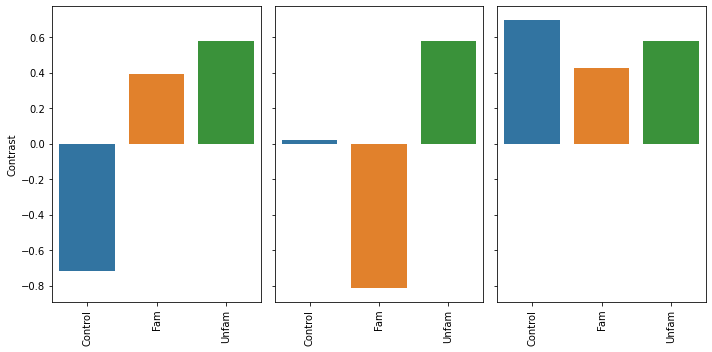

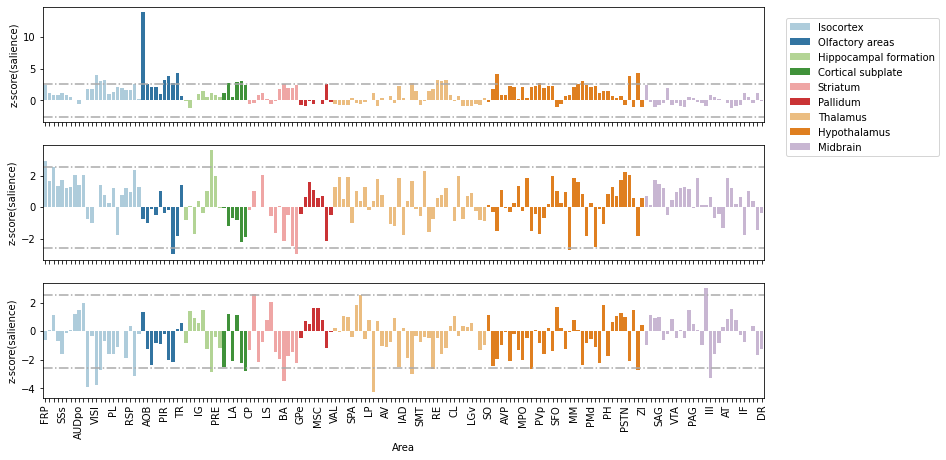

In [11]:
upls.plot_panel_contrasts(batch=batch, variable='ncells')
upls.plot_panel_saliences(batch=batch, variable='ncells', df_levels=df_levels)

# PLS ENERGY

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

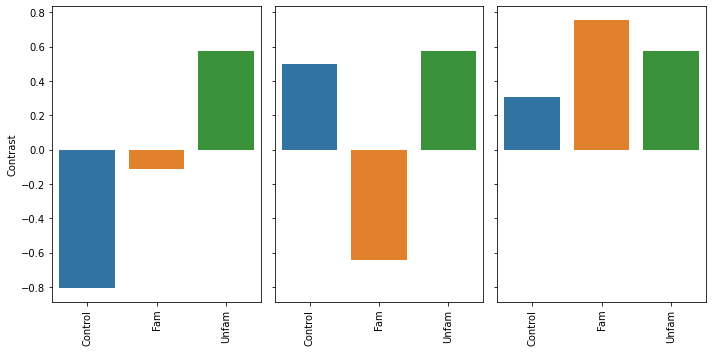

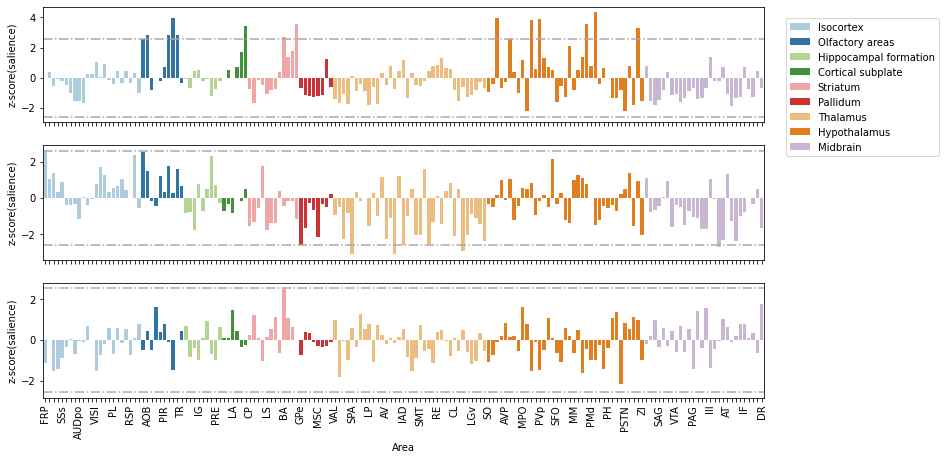

In [12]:
upls.plot_panel_contrasts(batch=batch, variable='energy')
upls.plot_panel_saliences(batch=batch, variable='energy', df_levels=df_levels)

# PLS density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

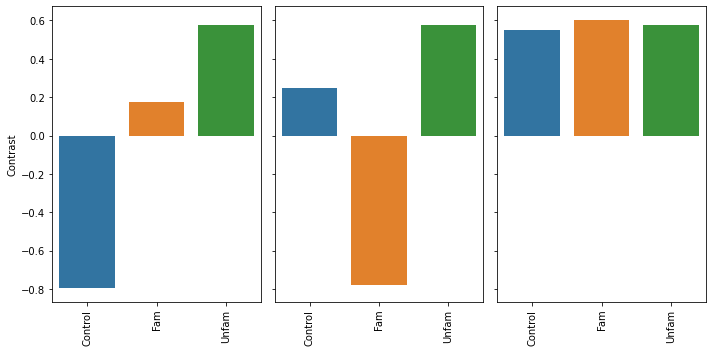

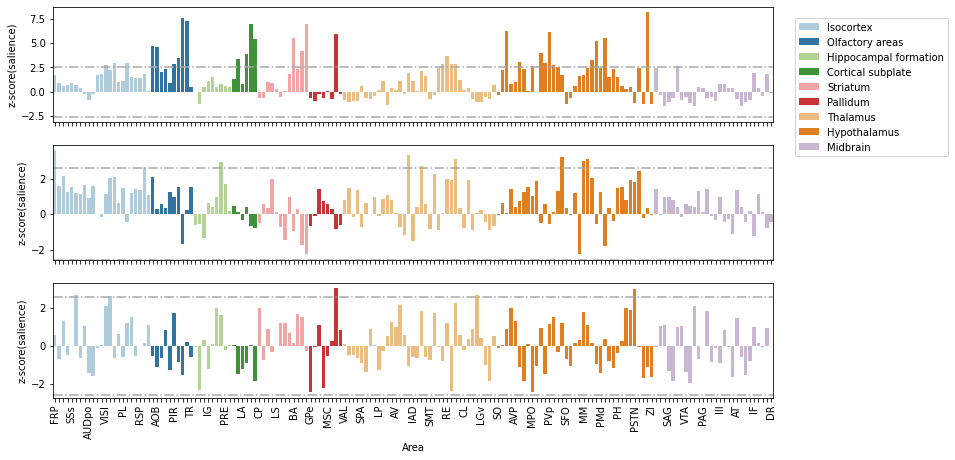

In [13]:
upls.plot_panel_contrasts(batch=batch, variable='density')
upls.plot_panel_saliences(batch=batch, variable='density', df_levels=df_levels)

# PLS relative density

(<Figure size 936x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

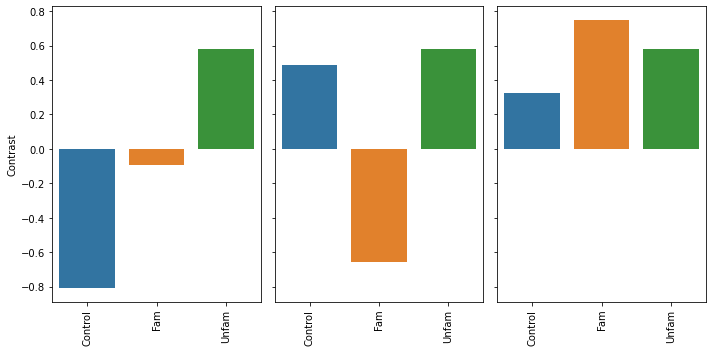

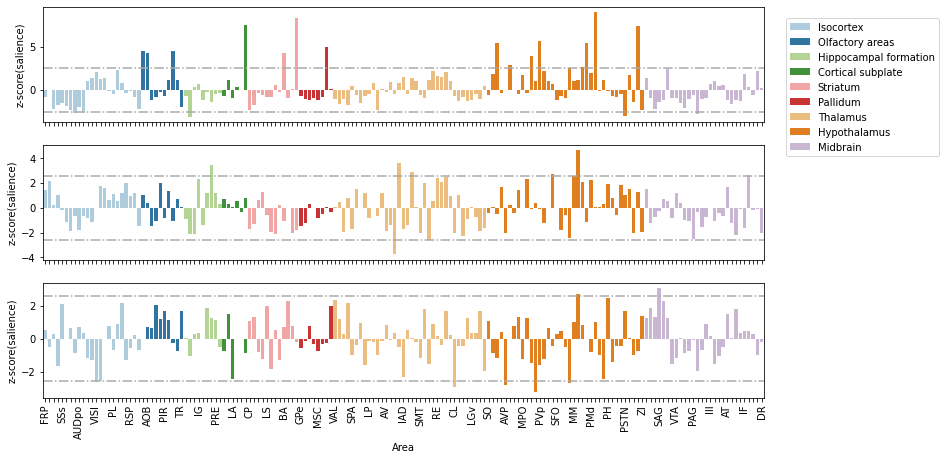

In [14]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

# Identify area overlap

In [15]:
overlap = {'ncells':[], 'energy':[], 'density':[], 'relative_density':[]}
for variable in overlap.keys():
    overlap[variable] = set(upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes))
[len(overlap[key]) for key in overlap.keys()]

[36, 20, 45, 35]

In [16]:
variable='relative_density'
control_vs_fam_vs_unfam = upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes)

# Only two groups

In [17]:
dict_results_across_mice = upls.reformat_dict_acronym(dict_results=dict_results_across_mice, volumes=volumes)

In [18]:
subject = list(dict_results_across_mice.keys())

In [19]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))

In [20]:
for ctrl in experimental_groups['Control']:
    del dict_results_across_mice[ctrl]

In [21]:
batch = 'c57_wf_fam_vs_unfam'
data_ncells = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='n_cells')
data_energy = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                   batch=batch, table='energy')
data_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                    batch=batch, table='density')
data_relative_density = upls.format_data_pls(dict_results=dict_results_across_mice, 
                                             batch=batch, table='relative_density')
data_ncells.dropna(inplace=True, axis=1)
data_energy.dropna(inplace=True, axis=1)
data_density.dropna(inplace=True, axis=1)
data_relative_density.dropna(inplace=True, axis=1)
data_ncells.to_csv('./results_pls/'+batch+'_n_cells.csv')
data_energy.to_csv('./results_pls/'+batch+'_energy.csv')
data_density.to_csv('./results_pls/'+batch+'_density.csv')
data_relative_density.to_csv('./results_pls/'+batch+'_relative_density.csv')

In [22]:
%%bash
python area_pls.py -i results_pls/c57_wf_fam_vs_unfam_relative_density.csv -o './results_pls/c57_wf_fam_vs_unfam_relative_density'

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:ylabel='Contrast'>, <AxesSubplot:>], dtype=object))

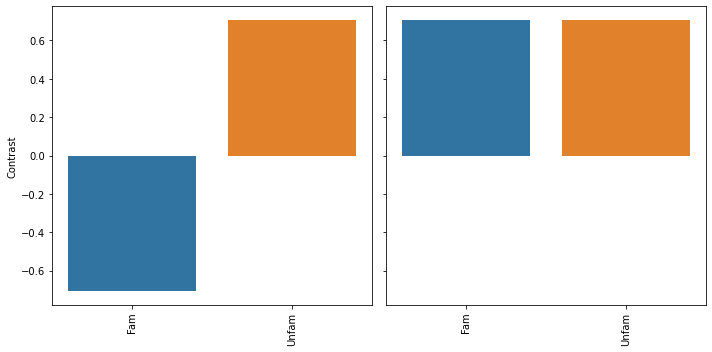

In [23]:
upls.plot_panel_contrasts(batch=batch, variable='relative_density')

(<Figure size 936x504 with 2 Axes>,
 array([<AxesSubplot:ylabel='z-score(salience)'>,
        <AxesSubplot:xlabel='Area', ylabel='z-score(salience)'>],
       dtype=object))

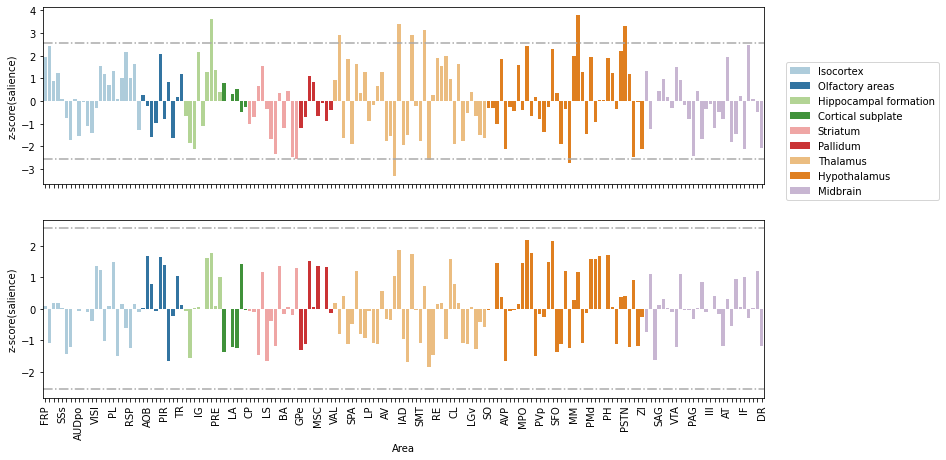

In [24]:
upls.plot_panel_saliences(batch=batch, variable='relative_density', df_levels=df_levels)

In [25]:
variable='relative_density'
fam_vs_unfam = upls.identify_pls_sig_areas(saliences=pd.read_csv(
        './results_pls/'+ batch +'_'+ variable +'_saliences.csv'), 
                                           threshold=2.56, 
                                           volumes=volumes)

In [26]:
control_vs_fam_vs_unfam


array(['Accessory olfactory bulb', 'Anterodorsal nucleus',
       'Anteroventral periventricular nucleus',
       'Anteroventral preoptic nucleus', 'Arcuate hypothalamic nucleus',
       'Bed nuclei of the stria terminalis',
       'Bed nucleus of the accessory olfactory tract',
       'Central lateral nucleus of the thalamus',
       'Cortical amygdalar area', 'Dentate gyrus',
       'Interanteromedial nucleus of the thalamus',
       'Intermediodorsal nucleus of the thalamus',
       'Interpeduncular nucleus', 'Lateral mammillary nucleus',
       'Lateral visual area', 'Main olfactory bulb',
       'Medial amygdalar nucleus', 'Medial mammillary nucleus',
       'Medial preoptic nucleus', 'Nucleus sagulum', 'Parastrial nucleus',
       'Parasubthalamic nucleus',
       'Paraventricular nucleus of the thalamus',
       'Periventricular hypothalamic nucleus posterior part',
       'Posterior amygdalar nucleus', 'Posterodorsal preoptic nucleus',
       'Postsubiculum', 'Pretectal region'

In [27]:
fam_vs_unfam

array(['Anterodorsal nucleus',
       'Interanteromedial nucleus of the thalamus',
       'Intermediodorsal nucleus of the thalamus',
       'Lateral mammillary nucleus', 'Parasubthalamic nucleus',
       'Paraventricular nucleus of the thalamus', 'Perireunensis nucleus',
       'Postsubiculum', 'Supramammillary nucleus',
       'Ventral medial nucleus of the thalamus'], dtype='<U41')

In [28]:
set(fam_vs_unfam).intersection(set(control_vs_fam_vs_unfam))

{'Anterodorsal nucleus',
 'Interanteromedial nucleus of the thalamus',
 'Intermediodorsal nucleus of the thalamus',
 'Lateral mammillary nucleus',
 'Parasubthalamic nucleus',
 'Paraventricular nucleus of the thalamus',
 'Postsubiculum',
 'Supramammillary nucleus'}